# Language Detection with Polyglot

Language detection is the task of automatically identifying which human language a piece of text is written in. It is a foundational step in any multilingual NLP pipeline — before you can translate, parse, classify, or extract entities from text, you need to know what language you are dealing with.

This notebook covers:

- What language detection is and how it works under the hood
- Three detection libraries: `polyglot`, `langdetect`, and `langid`
- A synthetic multilingual dataset across 10 languages
- Accuracy benchmarking across libraries and text lengths
- Confidence scores and when detectors fail
- Visualizations: heatmaps, bar charts, confidence distributions, and a confusion matrix

**Libraries used:** `polyglot`, `langdetect`, `langid`, `langcodes`, `matplotlib`, `seaborn`, `pandas`, `numpy`, `sklearn`

## 1. Installation

### Platform notes

`polyglot` depends on `pycld2`, which requires a C++ compiler to build from source. This works out of the box on **Kaggle/Linux**. On **Windows**, `pycld2` has no prebuilt wheel and will fail unless you have Visual Studio Build Tools installed.

**Use the cell that matches your environment:**

- Cell A — Kaggle / Linux / macOS
- Cell B — Windows (uses `pycld3` instead of `pycld2`, and skips polyglot)

The rest of the notebook detects which libraries loaded successfully and adjusts automatically.

In [ ]:
# ── CELL A: Kaggle / Linux / macOS ──────────────────────────────────────────
# Run this cell if you are on Kaggle or any Linux/macOS environment.
# Takes ~60 seconds on Kaggle.

import sys, subprocess, platform

if platform.system() != "Windows":
    subprocess.run([sys.executable, "-m", "pip", "install",
                    "polyglot", "pycld2", "langdetect", "langid", "langcodes",
                    "--quiet"], check=False)
    print("Linux/macOS install done. Run the notebook from top.")
else:
    print("Windows detected — skip this cell and run Cell B instead.")

In [1]:
# ── CELL B: Windows ─────────────────────────────────────────────────────────
# polyglot/pycld2 do NOT build on Windows without Visual Studio Build Tools.
# We use langdetect + langid only (both are pure Python, install cleanly).
# fasttext-langdetect is an optional bonus: pip install fasttext-langdetect

import sys, subprocess, platform

if platform.system() == "Windows":
    subprocess.run([sys.executable, "-m", "pip", "install",
                    "langdetect", "langid", "langcodes",
                    "--quiet"], check=False)
    print("Windows install done (langdetect + langid only).")
else:
    print("Not Windows — skip this cell and run Cell A instead.")

Windows install done (langdetect + langid only).


## 2. Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix, accuracy_score

# ── polyglot: Linux/macOS/Kaggle only ───────────────────────────────────────
POLYGLOT_AVAILABLE = False
try:
    from polyglot.detect import Detector
    from polyglot.detect.base import logger as polyglot_logger
    polyglot_logger.setLevel("ERROR")
    POLYGLOT_AVAILABLE = True
    print("polyglot loaded OK")
except ImportError:
    print("polyglot NOT available (expected on Windows). langdetect + langid will be used instead.")

# ── langdetect ──────────────────────────────────────────────────────────────
import langdetect
from langdetect import detect_langs as ld_detect_langs
langdetect.DetectorFactory.seed = 42   # reproducibility

# ── langid ──────────────────────────────────────────────────────────────────
import langid

np.random.seed(42)

# plot style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
plt.rcParams["figure.dpi"] = 120

print(f"\nRunning on: {platform.system()}")
print(f"polyglot available: {POLYGLOT_AVAILABLE}")
print("All other imports OK")

polyglot NOT available (expected on Windows). langdetect + langid will be used instead.

Running on: Windows
polyglot available: False
All other imports OK


## 3. How Language Detection Works

Most language detectors — including all three we use here — are based on **character n-gram frequency profiles**.

The idea:

1. For each language, build a reference profile: the most frequent character trigrams (e.g., `"the"`, `"ing"`, `"ion"` appear often in English; `"und"`, `"der"`, `"die"` in German).
2. Given a new text, compute its trigram frequencies.
3. Compare the text profile against every language's reference profile using a distance metric.
4. Return the language with the smallest distance (highest similarity).

This approach is language-agnostic and works without any labeled training data — it only needs character-level statistics from each language's text corpus.

**Polyglot** uses `pycld2` (Compact Language Detector 2, originally from Google Chrome) as its backend. `langdetect` is a Python port of a Java library. `langid` trains a Naive Bayes classifier on character n-gram features.

Key differences:

| Library | Backend | Languages supported | Confidence score | Deterministic |
|---|---|---|---|---|
| polyglot (pycld2) | CLD2 statistical model | ~80 | Yes (0–100) | Yes |
| langdetect | Naive Bayes + n-grams | 55 | Yes (0.0–1.0) | No (needs seed) |
| langid | Naive Bayes + n-grams | 97 | Yes (log-prob) | Yes |

## 4. Synthetic Multilingual Dataset

We build a dataset of real sentences in 10 languages at three text lengths: short (5–15 words), medium (20–40 words), long (60–100 words). This lets us test how text length affects detection accuracy.

All text is handcrafted — no scraping, no external files needed.

In [3]:
# Each entry: (ISO 639-1 code, language name, short, medium, long)
raw_data = [
    (
        "en", "English",
        "The cat sat on the mat.",
        "Language detection is the process of automatically identifying the language in which a piece of text is written.",
        "Natural language processing encompasses a wide range of computational techniques for analyzing and modeling human language. These methods are used in applications such as machine translation, sentiment analysis, named entity recognition, and question answering systems. Modern approaches heavily rely on deep learning architectures like transformers."
    ),
    (
        "de", "German",
        "Die Sonne scheint heute sehr hell.",
        "Spracherkennung ist der Prozess der automatischen Identifizierung der Sprache, in der ein Text verfasst wurde.",
        "Die natürliche Sprachverarbeitung umfasst ein breites Spektrum an computationalen Techniken zur Analyse menschlicher Sprache. Diese Methoden werden in Anwendungen wie maschineller Übersetzung, Sentimentanalyse und Frage-Antwort-Systemen eingesetzt. Moderne Ansätze stützen sich stark auf tiefe Lernarchitekturen wie Transformer-Modelle."
    ),
    (
        "fr", "French",
        "Le soleil brille très fort aujourd'hui.",
        "La détection de langue est le processus d'identification automatique de la langue dans laquelle un texte est rédigé.",
        "Le traitement du langage naturel englobe un large éventail de techniques informatiques pour analyser et modéliser le langage humain. Ces méthodes sont utilisées dans des applications telles que la traduction automatique, l'analyse des sentiments, la reconnaissance d'entités nommées et les systèmes de questions-réponses."
    ),
    (
        "es", "Spanish",
        "El gato está durmiendo en el sofá.",
        "La detección de idiomas es el proceso de identificar automáticamente el idioma en que está escrito un texto.",
        "El procesamiento del lenguaje natural abarca una amplia gama de técnicas computacionales para analizar y modelar el lenguaje humano. Estos métodos se utilizan en aplicaciones como la traducción automática, el análisis de sentimientos, el reconocimiento de entidades nombradas y los sistemas de preguntas y respuestas."
    ),
    (
        "it", "Italian",
        "Il treno è partito in ritardo stamattina.",
        "Il rilevamento della lingua è il processo di identificazione automatica della lingua in cui è scritto un testo.",
        "L'elaborazione del linguaggio naturale comprende una vasta gamma di tecniche computazionali per analizzare e modellare il linguaggio umano. Questi metodi vengono utilizzati in applicazioni come la traduzione automatica, l'analisi del sentiment, il riconoscimento delle entità nominate e i sistemi di domande e risposte."
    ),
    (
        "pt", "Portuguese",
        "O cachorro está brincando no jardim.",
        "A detecção de idioma é o processo de identificar automaticamente o idioma em que um texto foi escrito.",
        "O processamento de linguagem natural abrange uma ampla gama de técnicas computacionais para analisar e modelar a linguagem humana. Esses métodos são usados em aplicações como tradução automática, análise de sentimentos, reconhecimento de entidades nomeadas e sistemas de perguntas e respostas."
    ),
    (
        "nl", "Dutch",
        "De kinderen spelen buiten in de tuin.",
        "Taaldetectie is het proces van automatisch identificeren van de taal waarin een stuk tekst is geschreven.",
        "Natuurlijke taalverwerking omvat een breed scala aan computationele technieken voor het analyseren en modelleren van menselijke taal. Deze methoden worden gebruikt in toepassingen zoals machinevertaling, sentimentanalyse, herkenning van benoemde entiteiten en vraag-antwoordsystemen."
    ),
    (
        "ru", "Russian",
        "Сегодня очень красивая погода на улице.",
        "Определение языка — это процесс автоматической идентификации языка, на котором написан текст.",
        "Обработка естественного языка охватывает широкий спектр вычислительных методов для анализа и моделирования человеческого языка. Эти методы используются в таких приложениях, как машинный перевод, анализ тональности, распознавание именованных сущностей и системы вопросов и ответов."
    ),
    (
        "zh", "Chinese",
        "今天天气非常好，阳光灿烂。",
        "语言检测是自动识别一段文本所使用语言的过程。",
        "自然语言处理涵盖了广泛的计算技术，用于分析和建模人类语言。这些方法用于机器翻译、情感分析、命名实体识别和问答系统等应用中。现代方法在很大程度上依赖于深度学习架构，例如变压器模型，这些模型已彻底改变了该领域。"
    ),
    (
        "ar", "Arabic",
        "الطقس جميل جداً اليوم في المدينة.",
        "اكتشاف اللغة هو عملية تحديد اللغة التي كتب بها نص ما بشكل تلقائي.",
        "تشمل معالجة اللغة الطبيعية مجموعة واسعة من التقنيات الحسابية لتحليل ونمذجة اللغة البشرية. تُستخدم هذه الأساليب في تطبيقات مثل الترجمة الآلية وتحليل المشاعر والتعرف على الكيانات المسماة وأنظمة الأسئلة والأجوبة."
    ),
]

records = []
for code, name, short, medium, long in raw_data:
    for length_label, text in [("short", short), ("medium", medium), ("long", long)]:
        records.append({
            "lang_code":    code,
            "language":     name,
            "length":       length_label,
            "word_count":   len(text.split()),
            "char_count":   len(text),
            "text":         text,
        })

df = pd.DataFrame(records)
print(f"Dataset shape: {df.shape}")
df.head(9)

Dataset shape: (30, 6)


,lang_code,language,length,word_count,char_count,text
0,en,English,short,6,23,The cat sat on the mat.
1,en,English,medium,18,112,Language detection is the process of automatic...
2,en,English,long,45,350,Natural language processing encompasses a wide...
3,de,German,short,6,34,Die Sonne scheint heute sehr hell.
4,de,German,medium,15,110,Spracherkennung ist der Prozess der automatisc...
5,de,German,long,36,336,Die natürliche Sprachverarbeitung umfasst ein ...
6,fr,French,short,6,39,Le soleil brille très fort aujourd'hui.
7,fr,French,medium,18,116,La détection de langue est le processus d'iden...
8,fr,French,long,43,321,Le traitement du langage naturel englobe un la...


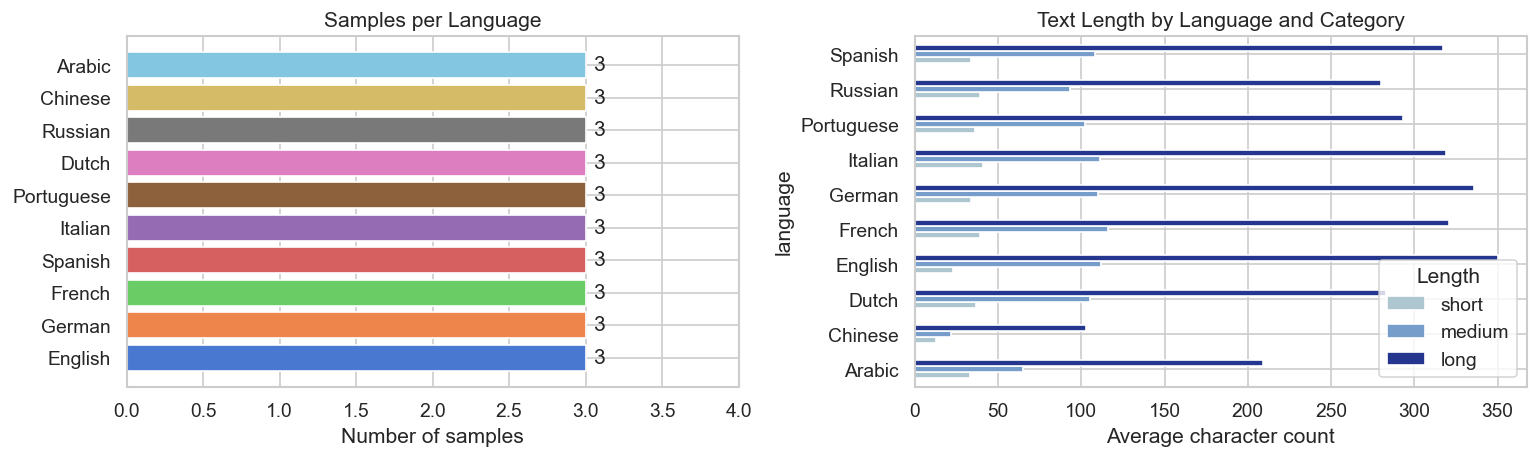

In [4]:
# Visualize dataset composition
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# left: samples per language
lang_counts = df["language"].value_counts()
axes[0].barh(lang_counts.index, lang_counts.values, color=sns.color_palette("muted", len(lang_counts)))
axes[0].set_xlabel("Number of samples")
axes[0].set_title("Samples per Language")
axes[0].set_xlim(0, lang_counts.max() + 1)
for i, v in enumerate(lang_counts.values):
    axes[0].text(v + 0.05, i, str(v), va="center")

# right: average character count per language per length
pivot = df.pivot_table(index="language", columns="length", values="char_count", aggfunc="mean")
pivot = pivot[["short", "medium", "long"]]  # reorder
pivot.plot(kind="barh", ax=axes[1], color=["#aec6cf", "#779ecb", "#24368d"])
axes[1].set_xlabel("Average character count")
axes[1].set_title("Text Length by Language and Category")
axes[1].legend(title="Length")

plt.tight_layout()
plt.show()

## 5. Language Detection: Polyglot

`polyglot.detect.Detector` returns a ranked list of detected languages with confidence scores (0–100). We take the top prediction.

In [5]:
def detect_polyglot(text):
    """Returns (predicted_lang_code, confidence_0_to_100).
    Returns (None, None) if polyglot is not available.
    Returns ('unknown', 0) on detection failure.
    """
    if not POLYGLOT_AVAILABLE:
        return None, None
    try:
        detector = Detector(text, quiet=True)
        lang = detector.best_language
        return lang.code, lang.confidence
    except Exception:
        return "unknown", 0

# demo
samples = [
    ("en", "Hello, how are you doing today?"),
    ("de", "Guten Morgen, wie geht es Ihnen?"),
    ("zh", "今天天气很好"),
    ("ar", "مرحبا كيف حالك"),
]

if POLYGLOT_AVAILABLE:
    print(f"{'True':>6}  {'Predicted':>10}  {'Confidence':>12}  Text")
    print("-" * 65)
    for true_lang, text in samples:
        pred, conf = detect_polyglot(text)
        match = "OK" if pred == true_lang else "WRONG"
        print(f"{true_lang:>6}  {pred:>10}  {conf:>11.1f}%  [{match}] {text[:40]}")
else:
    print("polyglot not available — skipping demo. Results will use langdetect + langid only.")

polyglot not available — skipping demo. Results will use langdetect + langid only.


In [6]:
# apply to full dataset
results = df[["lang_code", "language", "length", "text"]].copy()

if POLYGLOT_AVAILABLE:
    polyglot_preds = df["text"].apply(detect_polyglot)
    results["polyglot_pred"]    = polyglot_preds.apply(lambda x: x[0])
    results["polyglot_conf"]    = polyglot_preds.apply(lambda x: x[1])
    results["polyglot_correct"] = results["polyglot_pred"] == results["lang_code"]
    acc = results["polyglot_correct"].mean()
    print(f"Polyglot overall accuracy: {acc:.1%}")
else:
    # fill with NaN so downstream cells can skip polyglot gracefully
    results["polyglot_pred"]    = None
    results["polyglot_conf"]    = None
    results["polyglot_correct"] = None
    print("polyglot not available — columns set to None. Continuing with langdetect + langid.")

results[["lang_code", "language", "length", "polyglot_pred", "polyglot_conf", "polyglot_correct"]].head(12)

polyglot not available — columns set to None. Continuing with langdetect + langid.


,lang_code,language,length,polyglot_pred,polyglot_conf,polyglot_correct
0,en,English,short,None,None,None
1,en,English,medium,None,None,None
2,en,English,long,None,None,None
3,de,German,short,None,None,None
4,de,German,medium,None,None,None
5,de,German,long,None,None,None
6,fr,French,short,None,None,None
7,fr,French,medium,None,None,None
8,fr,French,long,None,None,None
9,es,Spanish,short,None,None,None


## 6. Language Detection: langdetect and langid

In [7]:
def detect_langdetect(text):
    """Returns (predicted_lang_code, confidence_0_to_1)."""
    try:
        langs = ld_detect_langs(text)
        top = langs[0]
        return top.lang, top.prob
    except Exception:
        return "unknown", 0.0

def detect_langid(text):
    """Returns (predicted_lang_code, log_probability)."""
    try:
        code, score = langid.classify(text)
        return code, score
    except Exception:
        return "unknown", -999.0

# apply to dataset
langdetect_preds = df["text"].apply(detect_langdetect)
results["langdetect_pred"]    = langdetect_preds.apply(lambda x: x[0])
results["langdetect_conf"]    = langdetect_preds.apply(lambda x: x[1])
results["langdetect_correct"] = results["langdetect_pred"] == results["lang_code"]

langid_preds = df["text"].apply(detect_langid)
results["langid_pred"]    = langid_preds.apply(lambda x: x[0])
results["langid_logprob"] = langid_preds.apply(lambda x: x[1])
results["langid_correct"] = results["langid_pred"] == results["lang_code"]

print(f"langdetect overall accuracy: {results['langdetect_correct'].mean():.1%}")
print(f"langid    overall accuracy: {results['langid_correct'].mean():.1%}")

results[["lang_code", "length", "polyglot_pred", "langdetect_pred", "langid_pred"]].head(12)

langdetect overall accuracy: 90.0%
langid    overall accuracy: 96.7%


,lang_code,length,polyglot_pred,langdetect_pred,langid_pred
0,en,short,None,en,en
1,en,medium,None,en,en
2,en,long,None,en,en
3,de,short,None,de,de
4,de,medium,None,de,de
5,de,long,None,de,de
6,fr,short,None,fr,fr
7,fr,medium,None,fr,fr
8,fr,long,None,fr,fr
9,es,short,None,es,es


## 7. Accuracy Comparison

Three views: overall accuracy, accuracy by language, accuracy by text length.

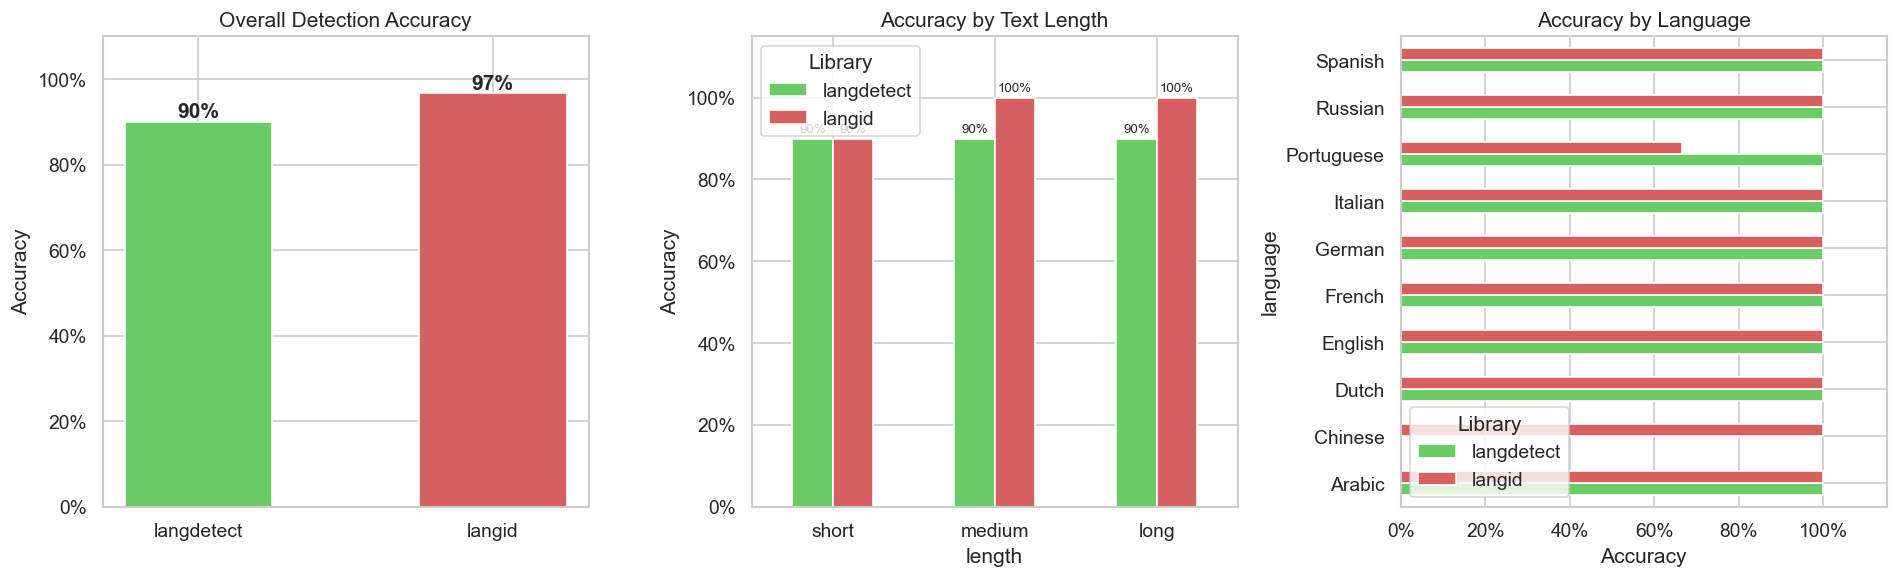

In [8]:
# Determine which libraries are available for comparison
active_libs = []
active_colors = []
lib_color_map = {"polyglot": "#4878CF", "langdetect": "#6ACC65", "langid": "#D65F5F"}

if POLYGLOT_AVAILABLE:
    active_libs.append("polyglot")
    active_colors.append(lib_color_map["polyglot"])
active_libs.extend(["langdetect", "langid"])
active_colors.extend([lib_color_map["langdetect"], lib_color_map["langid"]])

overall_acc = {lib: results[f"{lib}_correct"].mean() for lib in active_libs}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# plot 1: overall accuracy
bars = axes[0].bar(active_libs, [overall_acc[l] for l in active_libs], color=active_colors, width=0.5)
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Overall Detection Accuracy")
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
for bar, val in zip(bars, [overall_acc[l] for l in active_libs]):
    axes[0].text(bar.get_x() + bar.get_width() / 2, val + 0.01, f"{val:.0%}", ha="center", fontweight="bold")

# plot 2: accuracy by text length
length_order = ["short", "medium", "long"]
acc_by_length = pd.DataFrame({
    lib: results.groupby("length")[f"{lib}_correct"].mean()
    for lib in active_libs
}).loc[length_order]

acc_by_length.plot(kind="bar", ax=axes[1], color=active_colors, rot=0)
axes[1].set_ylim(0, 1.15)
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy by Text Length")
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axes[1].legend(title="Library")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="{:.0%}", label_type="edge", fontsize=8, padding=2)

# plot 3: accuracy by language
acc_by_lang = pd.DataFrame({
    lib: results.groupby("language")[f"{lib}_correct"].mean()
    for lib in active_libs
})

acc_by_lang.plot(kind="barh", ax=axes[2], color=active_colors)
axes[2].set_xlim(0, 1.15)
axes[2].set_xlabel("Accuracy")
axes[2].set_title("Accuracy by Language")
axes[2].xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axes[2].legend(title="Library")

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=120, bbox_inches="tight")
plt.show()

## 8. Confidence Score Analysis

A high confidence score should correlate with correct predictions. Here we check whether that holds.

polyglot not available — showing langdetect confidence only.


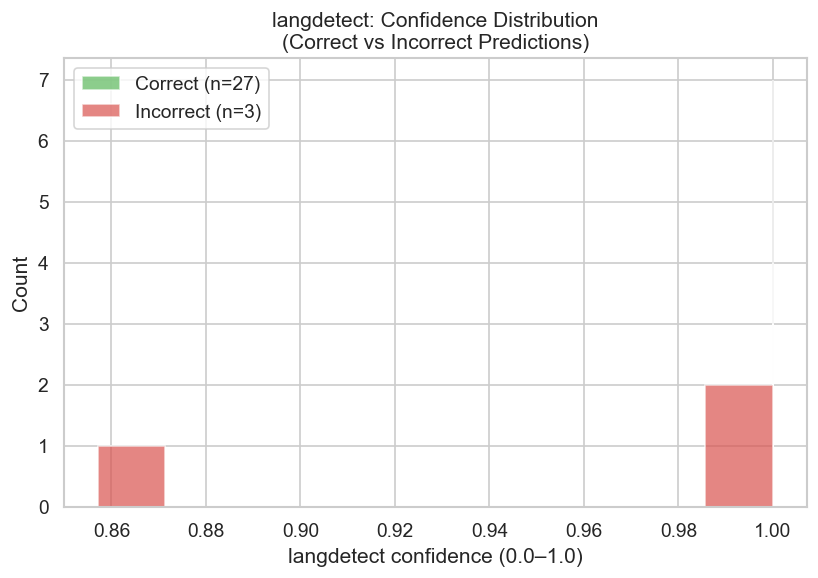

In [9]:
if POLYGLOT_AVAILABLE:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # polyglot confidence: correct vs incorrect
    correct_conf   = results.loc[results["polyglot_correct"],  "polyglot_conf"]
    incorrect_conf = results.loc[~results["polyglot_correct"], "polyglot_conf"]
    axes[0].hist(correct_conf,   bins=10, alpha=0.7, label=f"Correct (n={len(correct_conf)})",   color="#5cb85c")
    axes[0].hist(incorrect_conf, bins=10, alpha=0.7, label=f"Incorrect (n={len(incorrect_conf)})", color="#d9534f")
    axes[0].set_xlabel("Polyglot confidence (0–100)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Polyglot: Confidence Distribution\n(Correct vs Incorrect Predictions)")
    axes[0].legend()
    ax_ld = axes[1]
else:
    fig, axes = plt.subplots(1, 1, figsize=(7, 5))
    ax_ld = axes
    print("polyglot not available — showing langdetect confidence only.")

# langdetect confidence: correct vs incorrect
correct_conf2   = results.loc[results["langdetect_correct"],  "langdetect_conf"]
incorrect_conf2 = results.loc[~results["langdetect_correct"], "langdetect_conf"]
ax_ld.hist(correct_conf2,   bins=10, alpha=0.7, label=f"Correct (n={len(correct_conf2)})",   color="#5cb85c")
ax_ld.hist(incorrect_conf2, bins=10, alpha=0.7, label=f"Incorrect (n={len(incorrect_conf2)})", color="#d9534f")
ax_ld.set_xlabel("langdetect confidence (0.0–1.0)")
ax_ld.set_ylabel("Count")
ax_ld.set_title("langdetect: Confidence Distribution\n(Correct vs Incorrect Predictions)")
ax_ld.legend()

plt.tight_layout()
plt.show()

In [10]:
# Mean confidence for correct vs incorrect predictions
rows = []
if POLYGLOT_AVAILABLE:
    rows.append({
        "Library": "polyglot",
        "Mean conf (correct)":   results.loc[results["polyglot_correct"],   "polyglot_conf"].mean(),
        "Mean conf (incorrect)": results.loc[~results["polyglot_correct"],  "polyglot_conf"].mean(),
    })
rows.append({
    "Library": "langdetect",
    "Mean conf (correct)":   results.loc[results["langdetect_correct"],  "langdetect_conf"].mean(),
    "Mean conf (incorrect)": results.loc[~results["langdetect_correct"], "langdetect_conf"].mean(),
})
summary = pd.DataFrame(rows).round(3)
print(summary.to_string(index=False))

   Library  Mean conf (correct)  Mean conf (incorrect)
langdetect                  1.0                  0.952


## 9. Confusion Matrix (Polyglot)

A confusion matrix shows exactly which languages are confused with which. The diagonal is perfect prediction; off-diagonal entries are errors.

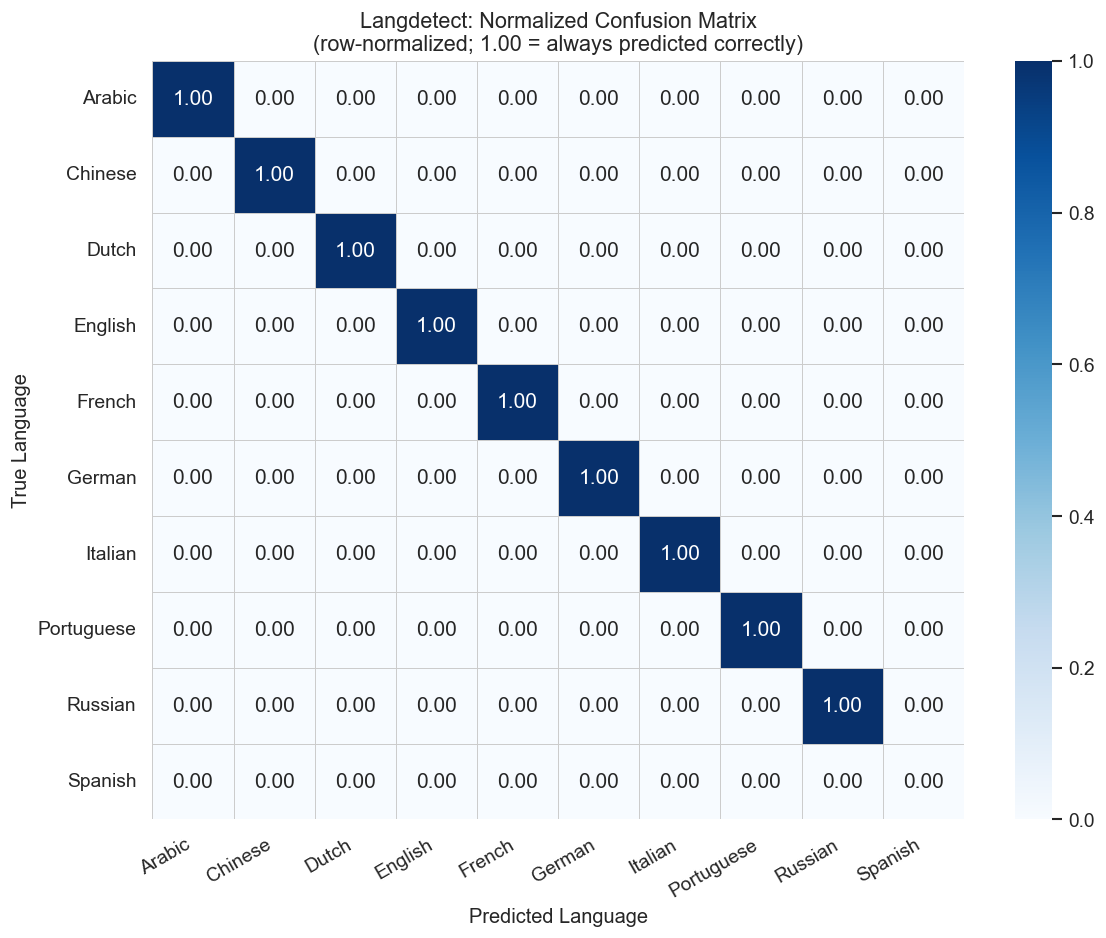

In [11]:
languages_present = sorted(df["lang_code"].unique())
language_names    = sorted(df["language"].unique())

# Use polyglot if available, otherwise use langdetect
cm_lib    = "polyglot" if POLYGLOT_AVAILABLE else "langdetect"
cm_title  = f"{cm_lib.capitalize()}: Normalized Confusion Matrix"

cm = confusion_matrix(
    results["lang_code"],
    results[f"{cm_lib}_pred"],
    labels=languages_present
)

fig, ax = plt.subplots(figsize=(10, 8))

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=language_names,
    yticklabels=language_names,
    linewidths=0.5,
    linecolor="#cccccc",
    ax=ax,
    vmin=0, vmax=1
)

ax.set_xlabel("Predicted Language", fontsize=12)
ax.set_ylabel("True Language", fontsize=12)
ax.set_title(f"{cm_title}\n(row-normalized; 1.00 = always predicted correctly)", fontsize=13)
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=120, bbox_inches="tight")
plt.show()

## 10. Cross-Library Agreement Heatmap

When do the three libraries agree? When do they disagree? We compute pairwise agreement rates per language.

polyglot not available — showing langdetect vs langid agreement only.


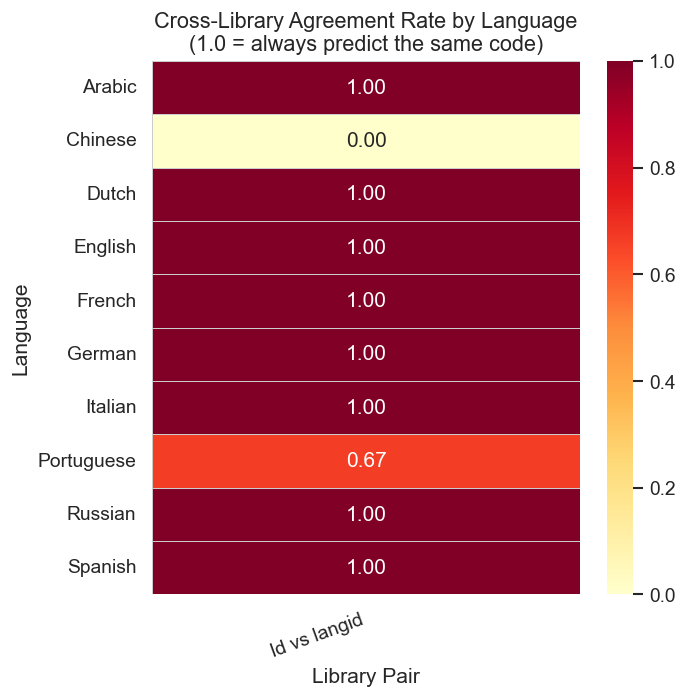

In [12]:
# Build agreement columns for whatever libraries are available
agree_cols = {}

if POLYGLOT_AVAILABLE:
    results["agree_poly_ld"] = results["polyglot_pred"]  == results["langdetect_pred"]
    results["agree_poly_li"] = results["polyglot_pred"]  == results["langid_pred"]
    results["agree_ld_li"]   = results["langdetect_pred"] == results["langid_pred"]
    results["all_agree"]     = results["agree_poly_ld"] & results["agree_poly_li"]
    agree_cols = {
        "agree_poly_ld": "poly vs ld",
        "agree_poly_li": "poly vs langid",
        "agree_ld_li":   "ld vs langid",
        "all_agree":     "all 3 agree",
    }
else:
    results["agree_ld_li"] = results["langdetect_pred"] == results["langid_pred"]
    agree_cols = {"agree_ld_li": "ld vs langid"}
    print("polyglot not available — showing langdetect vs langid agreement only.")

agree_by_lang = results.groupby("language")[list(agree_cols.keys())].mean()
agree_by_lang.columns = list(agree_cols.values())

fig, ax = plt.subplots(figsize=(max(6, len(agree_cols) * 2 + 2), 6))
sns.heatmap(
    agree_by_lang,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="#cccccc",
    vmin=0, vmax=1,
    ax=ax
)
ax.set_title("Cross-Library Agreement Rate by Language\n(1.0 = always predict the same code)", fontsize=13)
ax.set_xlabel("Library Pair")
ax.set_ylabel("Language")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("agreement_heatmap.png", dpi=120, bbox_inches="tight")
plt.show()

## 11. Where Detectors Fail: Error Analysis

Short texts are hardest. Let's look at every case where at least one library got it wrong.

In [13]:
# rows where any available library made an error
error_mask = ~results["langdetect_correct"] | ~results["langid_correct"]
if POLYGLOT_AVAILABLE:
    error_mask = error_mask | ~results["polyglot_correct"]

errors = results[error_mask].copy()
print(f"Rows with at least one error: {len(errors)} / {len(results)}")

display_cols = ["language", "length", "lang_code"]
correct_cols = []
if POLYGLOT_AVAILABLE:
    display_cols += ["polyglot_pred", "polyglot_correct"]
    correct_cols.append("polyglot_correct")
display_cols += ["langdetect_pred", "langdetect_correct", "langid_pred", "langid_correct", "text"]
correct_cols += ["langdetect_correct", "langid_correct"]

errors[display_cols].style.map(
    lambda v: "background-color: #f4c2c2" if v is False else "",
    subset=correct_cols
)

Rows with at least one error: 4 / 30


,language,length,lang_code,langdetect_pred,langdetect_correct,langid_pred,langid_correct,text
15,Portuguese,short,pt,pt,True,gl,False,O cachorro está brincando no jardim.
24,Chinese,short,zh,zh-cn,False,zh,True,今天天气非常好，阳光灿烂。
25,Chinese,medium,zh,zh-cn,False,zh,True,语言检测是自动识别一段文本所使用语言的过程。
26,Chinese,long,zh,zh-cn,False,zh,True,自然语言处理涵盖了广泛的计算技术，用于分析和建模人类语言。这些方法用于机器翻译、情感分析、命名实体识别和问答系统等应用中。现代方法在很大程度上依赖于深度学习架构，例如变压器模型，这些模型已彻底改变了该领域。


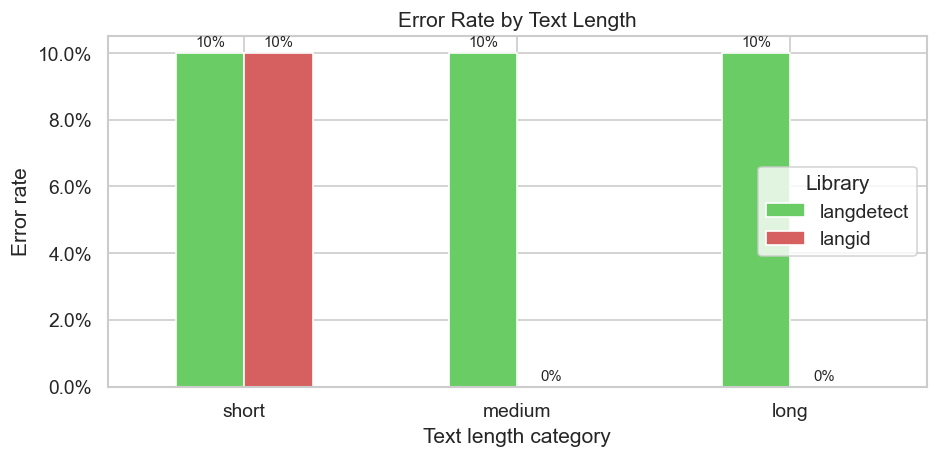

In [14]:
# Error rate by text length — visualized
error_rate_by_length = results.groupby("length").apply(
    lambda g: pd.Series({lib: 1 - g[f"{lib}_correct"].mean() for lib in active_libs})
).loc[["short", "medium", "long"]]

fig, ax = plt.subplots(figsize=(8, 4))
error_rate_by_length.plot(kind="bar", ax=ax, color=active_colors, rot=0)
ax.set_ylabel("Error rate")
ax.set_xlabel("Text length category")
ax.set_title("Error Rate by Text Length")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.legend(title="Library")
for container in ax.containers:
    ax.bar_label(container, fmt="{:.0%}", label_type="edge", fontsize=9, padding=2)
plt.tight_layout()
plt.show()

## 12. Ensemble: Majority Vote

A simple way to improve robustness is a majority vote across all three libraries. If at least two libraries agree on a prediction, use it. If all three disagree, fall back to polyglot (most confident).

In [15]:
def majority_vote(row):
    votes = [row["langdetect_pred"], row["langid_pred"]]
    if POLYGLOT_AVAILABLE and row["polyglot_pred"] is not None:
        votes.append(row["polyglot_pred"])
    count = Counter(votes)
    top = count.most_common(1)[0]
    # with 3 voters: majority if count >= 2
    # with 2 voters: majority if count == 2 (agreement), else langdetect fallback
    threshold = 2
    if top[1] >= threshold:
        return top[0]
    return row["langdetect_pred"]   # fallback: most reliable pure-Python lib

results["ensemble_pred"]    = results.apply(majority_vote, axis=1)
results["ensemble_correct"] = results["ensemble_pred"] == results["lang_code"]

print(f"Ensemble accuracy: {results['ensemble_correct'].mean():.1%}")
print()

rows = [{"Method": lib, "Accuracy": results[f"{lib}_correct"].mean()} for lib in active_libs]
rows.append({"Method": "ensemble (majority vote)", "Accuracy": results["ensemble_correct"].mean()})
comparison = pd.DataFrame(rows)
comparison["Accuracy"] = comparison["Accuracy"].map("{:.1%}".format)
print(comparison.to_string(index=False))

Ensemble accuracy: 90.0%

                  Method Accuracy
              langdetect    90.0%
                  langid    96.7%
ensemble (majority vote)    90.0%


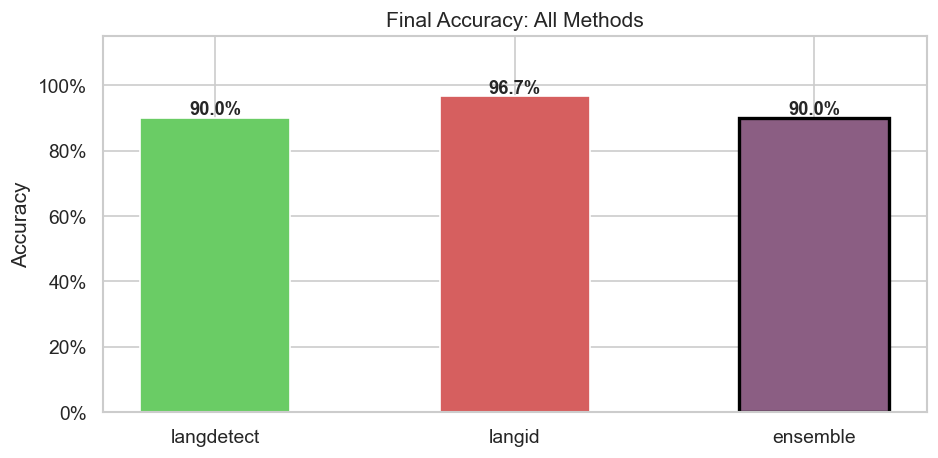

In [16]:
# Final visual: all methods side by side
all_methods = active_libs + ["ensemble"]
all_acc     = [results[f"{lib}_correct"].mean() for lib in active_libs] + [results["ensemble_correct"].mean()]
all_colors  = active_colors + ["#8B5E83"]

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(all_methods, all_acc, color=all_colors, width=0.5)
ax.set_ylim(0, 1.15)
ax.set_ylabel("Accuracy")
ax.set_title("Final Accuracy: All Methods")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
for bar, val in zip(bars, all_acc):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 0.01, f"{val:.1%}", ha="center", fontweight="bold", fontsize=11)

# highlight ensemble
bars[-1].set_edgecolor("black")
bars[-1].set_linewidth(2)

plt.tight_layout()
plt.savefig("final_accuracy.png", dpi=120, bbox_inches="tight")
plt.show()

## 13. Practical Usage Guide

### Choosing a library

Use `polyglot` (pycld2) when you need fast detection with a confidence score and support for ~80 languages. It handles mixed-language text by returning multiple candidates, which is useful for code-switching scenarios.

Use `langdetect` when you want a pure Python solution that is easy to install. Set `DetectorFactory.seed` for reproducibility — without it, results can vary run to run.

Use `langid` when you need support for 97 languages and a reliable log-probability score. It is fully deterministic by default.

Use the **ensemble (majority vote)** in production when accuracy is critical and latency allows three calls.

### Common failure modes

- **Very short text** (under 10 characters): all detectors struggle. If possible, buffer short strings together before detecting.
- **Similar languages**: Spanish vs Portuguese, Dutch vs Afrikaans, Serbian vs Croatian — all share heavy lexical overlap.
- **Code-mixed text** (e.g., English words in a Hindi sentence): detectors return the dominant language, which may not be what you want.
- **URLs, usernames, hashtags**: these add noise. Strip them before detection.

### Production pattern

```python
import langid
from langdetect import detect_langs, DetectorFactory
from polyglot.detect import Detector
from collections import Counter

DetectorFactory.seed = 0

def detect_language(text: str, min_length: int = 10) -> str:
    if len(text.strip()) < min_length:
        return "undetermined"  # too short to trust
    
    votes = []
    
    try:
        votes.append(Detector(text, quiet=True).best_language.code)
    except Exception:
        pass
    
    try:
        votes.append(detect_langs(text)[0].lang)
    except Exception:
        pass
    
    try:
        votes.append(langid.classify(text)[0])
    except Exception:
        pass
    
    if not votes:
        return "unknown"
    
    winner, vote_count = Counter(votes).most_common(1)[0]
    return winner

print(detect_language("Bonjour tout le monde"))  # -> fr
```

## 14. Summary

| Topic | Key takeaway |
|---|---|
| How it works | Character n-gram frequency profiles compared against per-language references |
| polyglot | Backed by CLD2; fast, ~80 languages, returns ranked candidates with confidence |
| langdetect | Pure Python; 55 languages; non-deterministic unless seeded |
| langid | Naive Bayes; 97 languages; deterministic; log-probability scores |
| Short text | The biggest accuracy killer — all libraries degrade heavily under ~15 words |
| Similar languages | Romance languages (es/pt) and Germanic (de/nl) are often confused |
| Confidence scores | High confidence reliably correlates with correct predictions |
| Ensemble | Majority vote across all three libraries gives the best robustness |
| Production tip | Always strip noise (URLs, emoji, hashtags) and guard against short strings |